In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
history_points = 50

In [5]:
def csv_to_dataset(path):
    global features_col
    features_col = []
    data = pd.read_csv(path)
    data = data.drop('Date', axis=1)
    cols = data.columns

    unscaled_y = data['Close']
 
    # 最大値を1, 最小値を０に変換
    data_normaliser = MinMaxScaler()
    data = data_normaliser.fit_transform(data)
    data = pd.DataFrame(data, columns=cols)
    data['raw_Close'] = unscaled_y
    
    
    def calc_ema(data, time_period):
        global features_col
        k = 2 / (1 - time_period)
        data['SMA'] = data['Close'].rolling(time_period).mean()
        data['EMA'] = data['Close'] * k +data['SMA'].shift(1) * (1 - k)
        data[['lag_1_SMA', 'lag_1_EMA']] = data[['SMA', 'EMA']].shift(1)
        features_col.append('lag_1_SMA')
        features_col.append('lag_1_EMA')
        return data

    
    def histories_nomalized(data):
        global features_col
        for i in range(1, history_points+1):
            for c in cols:
                col = 'lag_{}_{}'.format(i,c)
                data[col] = data[c].shift(i)
                features_col.append(col)
        return data
    
    
    data = calc_ema(data, 3)
    data = histories_nomalized(data)
    data.dropna(inplace=True)
    
    y_normaliser = MinMaxScaler()
    y_normaliser.fit(data['raw_Close'].values.reshape(-1,1))
    return data, y_normaliser

In [6]:
data, y_normaliser = csv_to_dataset('data/etf_4755.csv')

In [7]:
data.head()

,Open,High,Low,Close,Volume,raw_Close,SMA,EMA,lag_1_SMA,lag_1_EMA,...,lag_49_Open,lag_49_High,lag_49_Low,lag_49_Close,lag_49_Volume,lag_50_Open,lag_50_High,lag_50_Low,lag_50_Close,lag_50_Volume
50,0.833285,0.850470,0.840803,0.853456,0.031451,2110.5,0.841689,0.822407,0.837931,0.829526,...,0.573661,0.567274,0.566647,0.556215,0.039004,0.591317,0.589600,0.589639,0.599229,0.023849
51,0.858177,0.861340,0.844005,0.864729,0.101189,2129.5,0.850687,0.818649,0.841689,0.822407,...,0.544718,0.562280,0.556752,0.560368,0.050145,0.573661,0.567274,0.566647,0.556215,0.039004
52,0.869465,0.892479,0.836438,0.910412,0.117285,2206.5,0.876199,0.790962,0.850687,0.818649,...,0.570478,0.562573,0.574505,0.567191,0.026437,0.544718,0.562280,0.556752,0.560368,0.050145
53,0.890593,0.902468,0.891153,0.890537,0.070778,2173.0,0.888559,0.861861,0.876199,0.790962,...,0.567583,0.562280,0.578580,0.576090,0.025239,0.570478,0.562573,0.574505,0.567191,0.026437
54,0.876122,0.880435,0.883586,0.883714,0.035743,2161.5,0.894888,0.893405,0.888559,0.861861,...,0.564978,0.577262,0.562282,0.593889,0.055921,0.567583,0.562280,0.578580,0.576090,0.025239


In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.optimizers import Adam

Using TensorFlow backend.


In [9]:
TRAIN_SIZE = 0.8
N = int(data.shape[0]*TRAIN_SIZE)
HIDEEN_LAYER = 50
DROPOUT= 0.2
BATCH_SIZE = 32
EPOCHS=50
VALIDATION_SPLIT = 0.1

In [10]:
X_train = data[features_col][:N]
y_train = data['Close'][:N]
X_test = data[features_col][N:]
y_test = data['Close'][N:]

In [11]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [12]:
model = Sequential()
model.add(LSTM(HIDEEN_LAYER, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(DROPOUT))
model.add(Dense(20))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(64))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('linear'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
adam = Adam(lr=0.0005)

In [14]:
model.compile(optimizer=adam, loss='mse')

In [15]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True ,validation_split=VALIDATION_SPLIT)


Train on 896 samples, validate on 100 samples
Epoch 1/50
896/896 [==============================] - 20s 22ms/step - loss: 0.1530 - val_loss: 0.0651
Epoch 2/50
896/896 [==============================] - 15s 17ms/step - loss: 0.0575 - val_loss: 0.0614
Epoch 3/50
896/896 [==============================] - 15s 17ms/step - loss: 0.0484 - val_loss: 0.0396
Epoch 4/50
896/896 [==============================] - 16s 18ms/step - loss: 0.0352 - val_loss: 0.0047
Epoch 5/50
896/896 [==============================] - 16s 18ms/step - loss: 0.0186 - val_loss: 0.0056
Epoch 6/50
896/896 [==============================] - 15s 17ms/step - loss: 0.0170 - val_loss: 0.0089
Epoch 7/50
896/896 [==============================] - 15s 17ms/step - loss: 0.0141 - val_loss: 0.0068
Epoch 8/50
896/896 [==============================] - 16s 18ms/step - loss: 0.0149 - val_loss: 0.0070
Epoch 9/50
896/896 [==============================] - 15s 17ms/step - loss: 0.0120 - val_loss: 0.0042
Epoch 10/50
896/896 [==============

In [16]:
preds = model.predict(X_test)
preds_unscaled = y_normaliser.inverse_transform(preds)

In [17]:
y_test.reset_index(drop=True, inplace=True)
y_test_unscaled = y_normaliser.inverse_transform(y_test.values.reshape(-1,1))

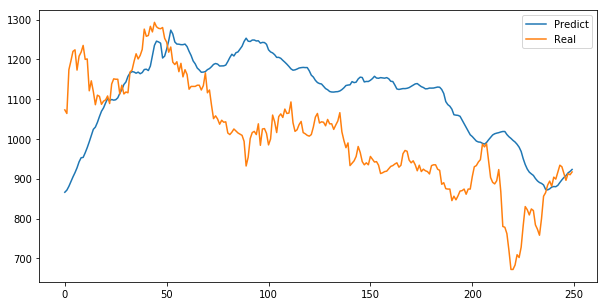

In [19]:
plt.figure(figsize=(10,5))
plt.plot(preds_unscaled, label='Predict')
plt.plot(y_test_unscaled, label='Real')
plt.legend()